In [1]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation
from statsmodels.genmod.families import Poisson

from mri_data import file_manager as fm

In [2]:
# reload_recursive(helpers)

## Load Data

### Clinical and Volumes

In [5]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/choroid_associations"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
csf_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/csf_volumes-dilM_sphere2.csv",
                          index_col='subid')

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt["SDMT"]])
df['csf_peripheral'] = csf_volumes['peripheral']
df['csf_all'] = csf_volumes['all']
df['csf_peripheral_frac'] = csf_volumes['peripheral'] / csf_volumes['all']
df["SDMT"] = pd.to_numeric(df["SDMT"], errors="coerce")
df["thalamus_sqrt"] = np.sqrt(df["thalamus"])
df["thalamus_curt"] = np.sqrt(df["thalamus"] ** 3)
df["cortical_thickness_inv"] = 1 / df["cortical_thickness"]
df["ventricle_logtrans"] = np.log(df["ventricle_volume"])

df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps["viridis"].resampled(20)

colors = helpers.get_colors()

### HIPS-THOMAS Volumes and Distances

In [4]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

ignore_structs1 = [
    "THALAMUS_1",
    "Amy_34",
    "GP_33",
    "Cla_28",
    "Acc_26",
    "Hb_13",
    "MTT_14",
]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

mni_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
    index_col="index",
)
mni_dists["struct"] = hips_thomas_ref

mni_dists2 = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_choroid_struct_SDT.csv",
    index_col="index",
)
mni_dists2["struct"] = hips_thomas_ref

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_centroid_centroid_dists.csv",
    index_col="index",
)
mni_ventricle_dists["struct"] = hips_thomas_ref


def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["intralaminar"] = df["CM_11"]
    df2["medial"] = df["MD_Pf_12"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


mni_combined_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_combined_nuclei_centroid_centroid_dists.csv",
    index_col="index",
)

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/p

Define centralization indices

In [51]:
df['CCF'] = df['ventricle_volume'] / df['csf_all']

df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

In [52]:
model_data = df[df['dz_type2'] == "MS"]
modelA = sm.OLS.from_formula("ventricle_volume ~ csf_all + age + Female + tiv", data=model_data).fit()
modelB = sm.OLS.from_formula("ventricle_volume ~ csf_all + brain + age + Female + tiv", data=model_data).fit()

print(modelA.summary())
print(modelB.summary())

model_data['DVE'] = modelA.resid

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     84.38
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           9.36e-54
Time:                        20:09:22   Log-Likelihood:                -5028.6
No. Observations:                 467   AIC:                         1.007e+04
Df Residuals:                     462   BIC:                         1.009e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.068e+04   8587.542     -3.572      0.0

(array([ 2.,  0.,  2.,  7., 21., 30., 50., 73., 87., 75., 63., 34., 31.,
        28., 11., 10., 12.,  5.,  5.,  6.,  2.,  2.,  0.,  2.,  0.,  2.,
         1.,  1.,  0.,  1.]),
 array([-1.93243218, -1.73485954, -1.5372869 , -1.33971427, -1.14214163,
        -0.94456899, -0.74699635, -0.54942371, -0.35185107, -0.15427844,
         0.0432942 ,  0.24086684,  0.43843948,  0.63601212,  0.83358475,
         1.03115739,  1.22873003,  1.42630267,  1.62387531,  1.82144795,
         2.01902058,  2.21659322,  2.41416586,  2.6117385 ,  2.80931114,
         3.00688377,  3.20445641,  3.40202905,  3.59960169,  3.79717433,
         3.99474696]),
 <BarContainer object of 30 artists>)

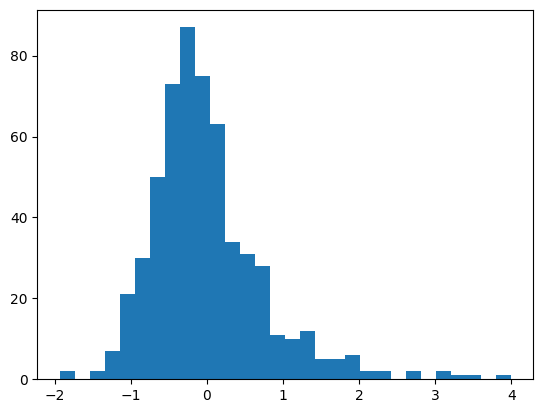

In [47]:
plt.hist(modelA.resid, bins=30)

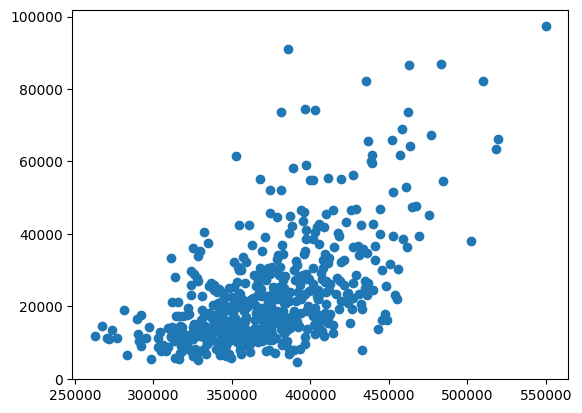

In [39]:
plt.scatter(df['csf_all'], df['ventricle_volume'])

In [60]:
model = sm.OLS.from_formula("DVE ~ t2lv + choroid_volume + age + Female + tiv", data=model_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    DVE   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     13.42
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           3.15e-12
Time:                        20:18:38   Log-Likelihood:                -4996.8
No. Observations:                 467   AIC:                         1.001e+04
Df Residuals:                     461   BIC:                         1.003e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5569.7655   8095.074     -0.

Ventricle volume as outcome, csf_peripheral is not significant while white is a covariate, but choroid volume is. Grey isnt important

In [31]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type3']=="MS"]

formula = "ventricle_volume ~ choroid_volume + white + age + Female + tiv"
result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     58.33
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           5.52e-47
Time:                        02:45:38   Log-Likelihood:                -558.90
No. Observations:                 467   AIC:                             1130.
Df Residuals:                     461   BIC:                             1155.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0293      0.037      0.

In [38]:
df['tiv']

subid
1001    1491310.000
1002    1457902.875
1003    1474545.000
1004    1256718.250
1005    1325065.500
           ...     
3016    1236729.250
3017    1652912.875
3021    1558369.500
3023    1451392.750
3028    1525758.750
Name: tiv, Length: 564, dtype: float64